In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

Importing the relevant packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import sep

In [ ]:
import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table
from astropy.table import Table

In [ ]:
catalog_name = "../data/sample_input_catalog.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

In [ ]:
stamp_size = 24.0  # Size of the stamp, in arcseconds
max_number = 6     # Maximum number of galaxies in a blend
max_shift = 2.0  # Maximum shift of the galaxies, in arcseconds
sampling_function = btk.sampling_functions.DefaultSampling(min_number=2,max_number=6, stamp_size=stamp_size, 
                                                           max_shift=max_shift, 
                                                           seed=seed) # random seed is used here!

In [ ]:
LSST = btk.survey.get_surveys("LSST")

In [ ]:
batch_size = 100
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    seed=seed, # same random seed is used here too!
)

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

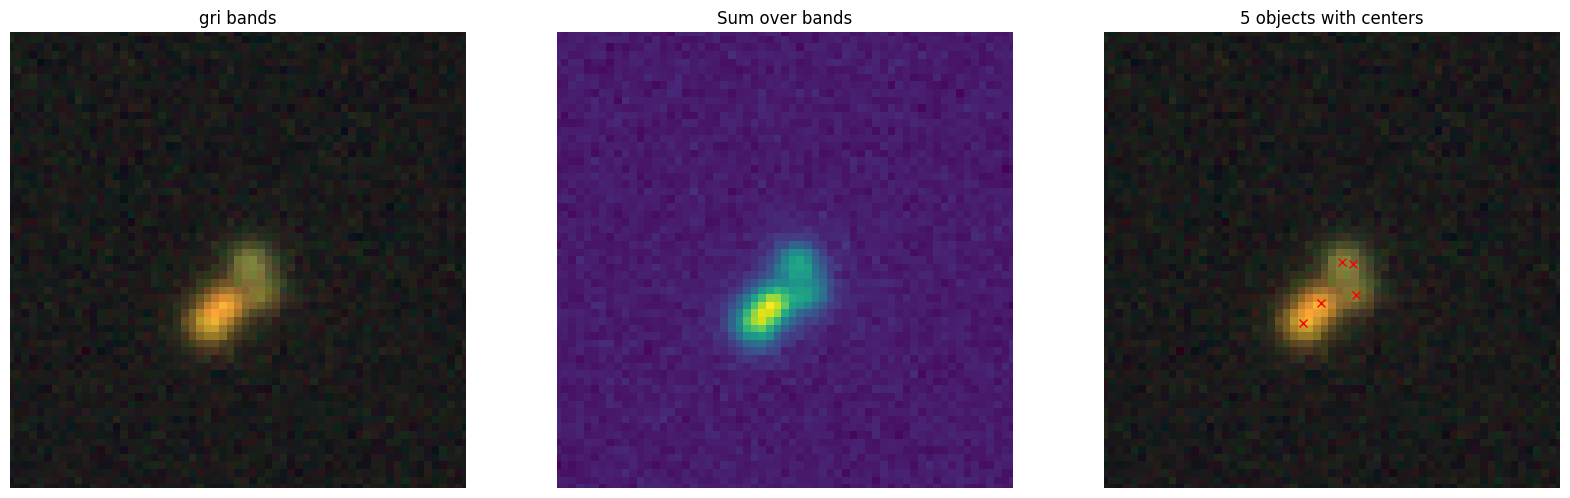

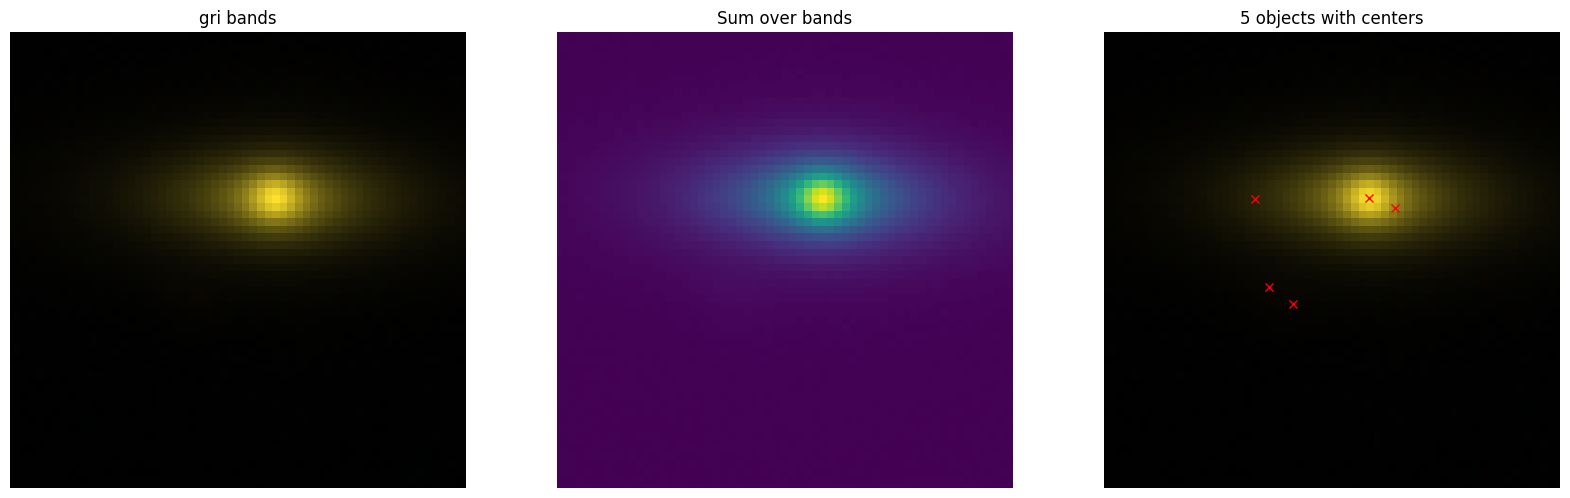

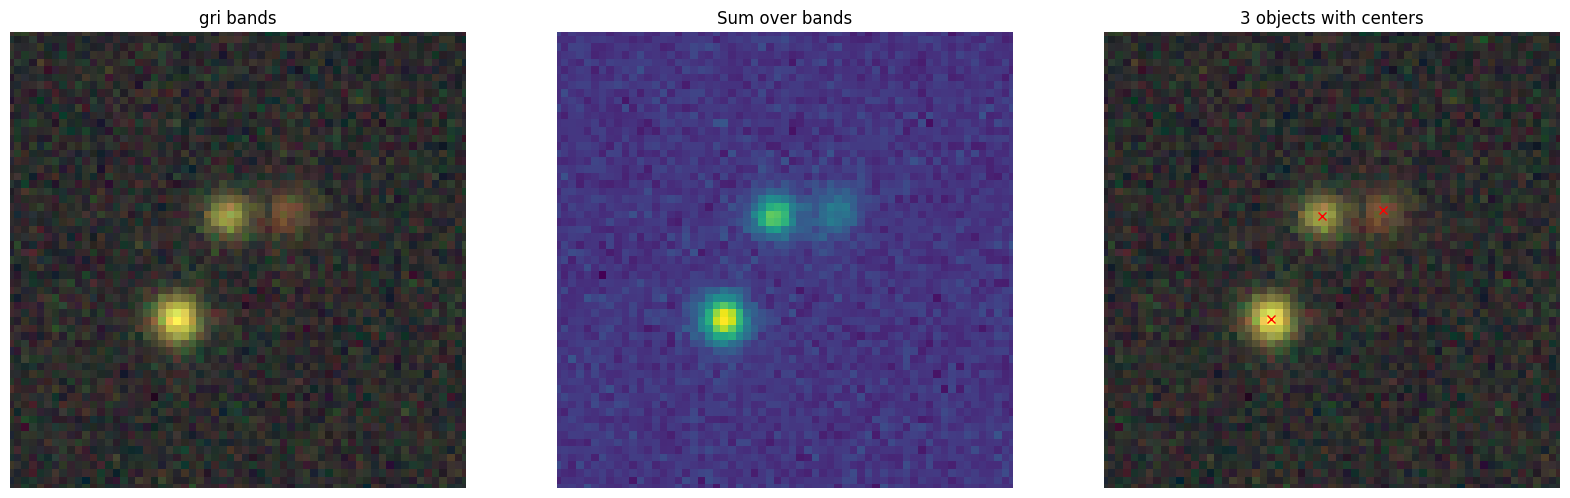

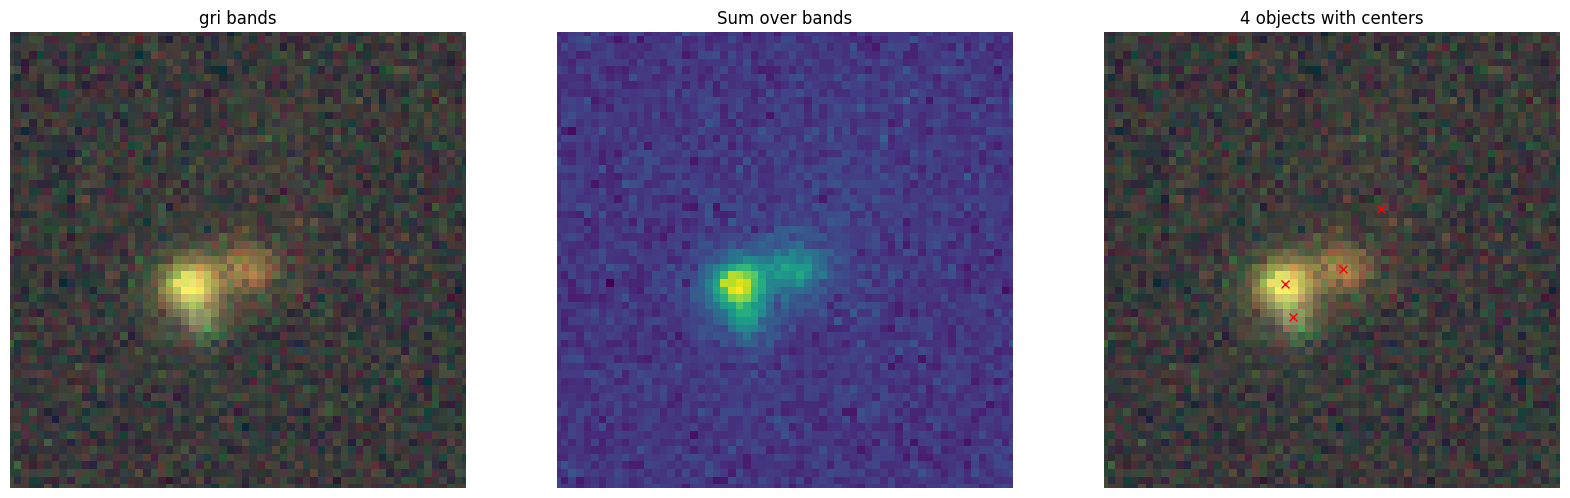

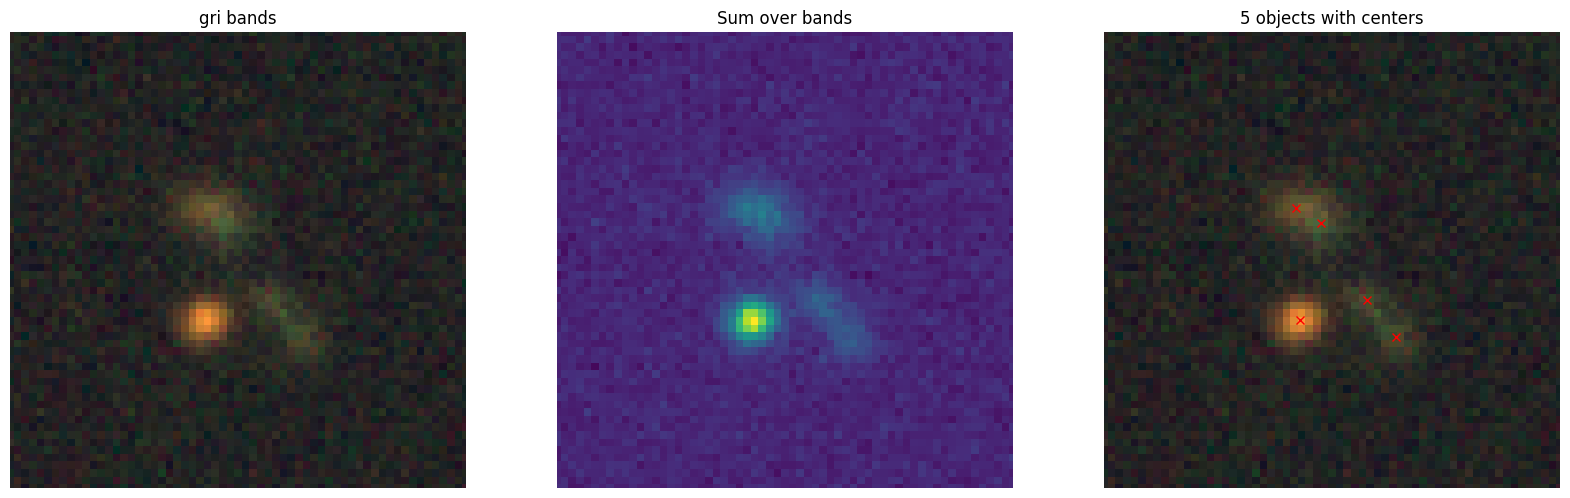

In [ ]:
batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
btk.plot_utils.plot_blends(blend_images[:5], blend_list[:5], limits=(30,90),norm="asinh",Q=0.1)

# Measure with SEP

In [ ]:
LSST.available_filters

['u', 'g', 'r', 'i', 'z', 'y']

In [ ]:
meas_generator = btk.measure.MeasureGenerator(btk.measure.sep_singleband_measure,draw_generator, 
                                              measure_kwargs=[{'use_mean':True}])                                                                                                        

In [ ]:
metrics_generator = btk.metrics.MetricsGenerator(meas_generator, meas_band_name="r")
blend_results,meas_results,results = next(metrics_generator)

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

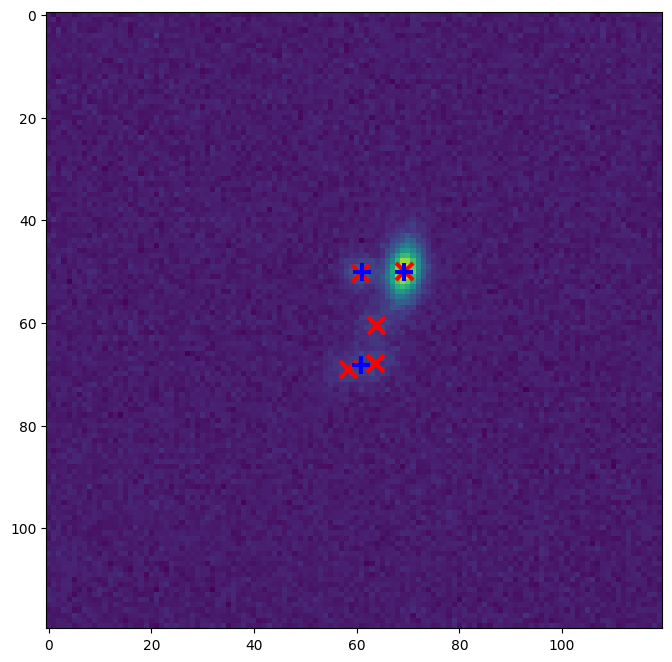

In [ ]:
i = 6
plt.figure(figsize=(8,8))
plt.imshow(blend_results['blend_images'][i][2])
blend_list = blend_results['blend_list']
detection_catalogs = meas_results["catalog"]["sep_singleband_measure"]
plt.scatter(
    blend_list[i]["x_peak"],
    blend_list[i]["y_peak"],
    color="red",
    marker="x",
    label="True centroids",
    s=150,
    linewidth=3,
)
plt.scatter(
    detection_catalogs[i]["x_peak"],
    detection_catalogs[i]["y_peak"],
    color="blue",
    marker="+",
    label="Detected centroids",
    s=150,
    linewidth=3,
)

# get fluxes via aperture photometry

In [ ]:
from galcheat.utilities import mag2counts, mean_sky_level
# use r band flux for now
# aperture photometry fluxes
detection_catalogs = meas_results["catalog"]["sep_singleband_measure"]
true_fluxes = []
r = LSST.get_filter('r')
psf_fwhm = r.psf_fwhm.to_value('arcsec') / LSST.pixel_scale.to_value('arcsec') # pixels
sky_level = mean_sky_level(LSST, r).to_value('electron') # mean = var
band_idx = 2
for ii in range(batch_size):
    image = blend_results['blend_images'][ii][band_idx]
    blend_table = blend_results['blend_list'][ii]
    iso_images = blend_results['isolated_images'][ii][:, band_idx, :, :]
    n_sources = len(blend_table)
    fluxes = np.zeros(n_sources)
    for jj in range(n_sources):
        all_iso_no_jj = np.sum([iso_images[kk] for kk in range(n_sources) if kk!=jj],axis=0)
        image_no_jj = image - all_iso_no_jj
        x_peak = blend_table['x_peak'][jj].item()
        y_peak = blend_table['y_peak'][jj].item()
        flux, _, _ = sep.sum_circle(image_no_jj, [x_peak], [y_peak], r=psf_fwhm, var=sky_level)
        fluxes[jj] = flux
    true_fluxes.append(fluxes)

In [ ]:
from galcheat.utilities import mag2counts, mean_sky_level
# use r band flux for now
detection_catalogs = meas_results["catalog"]["sep_singleband_measure"]
deblended_images = meas_results['deblended_images']['sep_singleband_measure']
pred_fluxes = []
r = LSST.get_filter('r')
band_idx = 2
for ii in range(batch_size):
    image = blend_results['blend_images'][ii][band_idx]
    detections_cat = detection_catalogs[ii]
    iso_images = deblended_images[ii][:, band_idx, :, :]
    n_sources = len(detections_cat)
    fluxes = np.zeros(n_sources)
    for jj in range(n_sources):
        all_iso_no_jj = np.sum([iso_images[kk] for kk in range(n_sources) if kk!=jj],axis=0)
        image_no_jj = image - all_iso_no_jj
        x_peak = detections_cat['x_peak'][jj].item()
        y_peak = detections_cat['y_peak'][jj].item()
        flux, _, _ = sep.sum_circle(image_no_jj, [x_peak], [y_peak], r=psf_fwhm, var=sky_level)
        fluxes[jj] = flux
    pred_fluxes.append(fluxes)

# Get mock data (per image)

In [ ]:
mock_truth = [Table() for i in range(batch_size)]
for ii in range(batch_size):
    t = blend_list[ii]
    mock_truth[ii].add_column(t['x_peak'].data, name='x')
    mock_truth[ii].add_column(t['y_peak'].data, name='y')
    mock_truth[ii].add_column(true_fluxes[ii], name='flux')

In [ ]:
mock_pred = [Table() for i in range(batch_size)]
for ii in range(batch_size):
    t = meas_results["catalog"]["sep_singleband_measure"][ii]
    mock_pred[ii].add_column(t['x_peak'].data, name='x')
    mock_pred[ii].add_column(t['y_peak'].data, name='y')
    mock_pred[ii].add_column(pred_fluxes[ii], name='flux')